# Extract Largest Eigenvalue of Symmetric Matrix with a Neural Network

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube

In [2]:
# Own implementations
%load_ext autoreload
%autoreload 2
from pinn import *

In [3]:
# Double-precision by default
torch.set_default_dtype(torch.float64)

In [70]:
def power_iteration(A, N=100):
    eigenvector = np.random.rand(A.shape[0])
    for i in range(N):
        eigenvector = A @ eigenvector
        norm = np.linalg.norm(eigenvector)
        eigenvector /= norm
    return eigenvector

### Helper functions

In [171]:
def rejection_sampling(pdf, n=1000, xmin=0, xmax=.98):
    x=torch.linspace(xmin,xmax,1000)  
    y=pdf(x)  
    pmin=0.  
    pmax=y.max()  
   
    naccept=0  
   
    ran=[] # output list of random numbers  
    while naccept<n:  
        x = (xmax - xmin) * torch.rand(1) + xmin  
        y = (pmax - pmin) * torch.rand(1) + pmin   
        
        if y<pdf(x):  
            ran.append(x)  
            naccept=naccept+1  
    
    return np.asarray(ran)  

def generate_random_symmetric_matrix(dim):
    M_random = torch.rand((dim,dim)) - 0.5
    return 0.5 * (M_random.T + M_random)

def eigenvalue_of_eigenvector(x, A):
    return (x @ A @ x.T) / (x @ x.T)

def noop(y, tau):
    return torch.zeros_like(y), torch.zeros_like(y)

### ODE specification

In [172]:
random_matrix = True

if random_matrix:
    dim = 6
    A = generate_random_symmetric_matrix(dim)
else:
    A = torch.tensor(1/4 * np.array([[1,2,3,4,5],[2,-1,-2,-3,-4],[3,-2,1,1,1],[4,-3,1,0,0],[5,-4,1,0,0]]))
    dim = A.shape[-1]
    
assert np.allclose(A, A.T, rtol=1e-8, atol=1e-10)
print(f"A = {A}")

# Coordinate transformations to bring the infinite time domain t \in [0,inf) to tau \in [0,1)

def dtau_dt_inv_identity(tau):
    return torch.ones_like(tau)

def dtau_dt_inv_tan(tau):
    """
    Assuming t = tan(pi/2 * tau) this is (dtau/dt)^(-1)
    """
    return torch.pi/(2 * torch.cos(torch.pi/2 * tau)**2)

def dtau_dt_inv_arctanh(tau):
    """
    Assuming t = arctanh(tau) this is (dtau/dt)^(-1)
    """
    return 1.0/(1.0 - tau**2)

# Random intial vector as initial condition. Function attributes used to fix the random vector across calls
def ic(y, tau):
    return y - ic.y0, torch.zeros_like(y)
ic.y0 = torch.rand(dim).reshape(1,-1)
#ic.y0 = ic.y0 @ A @ A @ A @ A
ic.y0 /= torch.sqrt(ic.y0 @ ic.y0.T).item()

# We can interpret the conservation property (d/dtau (y@y.T) = 0) of the ODE as boundary condition. 
# Note that we compare against a scalar property (the norm) and not a vector. Hence the difference in 
# the second return argument compared to ic() or eigenvector_ode()
def norm_conservation(y, tau):
    return torch.sqrt((y[:,None,:] @ y[:,:,None]).squeeze(-1)) - 1, torch.zeros_like(tau)

def eigenvector_ode(y, tau):    
    # Left hand side (LHS) of ODE
    y_tau = derivative(y, tau)
    # Right hand side (RHS) of ODE
    first_term = (y[:,None,:] @ (y[:,None,:] @ y[:,:,None] * A)).squeeze()
    second_term = (y[:,None,:] @ A @ y[:,:,None] @ y[:,None,:]).squeeze()
    #Prefactor of LHS due to coordinate transformation
    dtau_dt_inv = dtau_dt_inv_identity(tau)
    return y_tau - dtau_dt_inv * (first_term - second_term), torch.zeros_like(y)
eigenvector_ode.domain_dim=1
eigenvector_ode.target_dim=dim

# A solution form that adheres to the initial conditions explicitly
def trial_function(net_output, tau):
    return ic.y0 + tau * net_output
    
def temporal_sample(T, N_t, N_ic, N_bc, kind="lhs", function=dtau_dt_inv_identity):
    if kind == "lhs":
        sampler = lambda N: torch.from_numpy(T * LatinHypercube(1).random(n = N))
    elif kind == "uniform":
        sampler = lambda N: torch.from_numpy(np.linspace(0.01, .99*T, N).reshape(-1,1))
    elif kind == "rejection":
        sampler = lambda N: torch.from_numpy(rejection_sampling(function, n=N, xmin=0.01, xmax=.99*T)).reshape(-1,1)
    
    #Interior points
    samples_t = sampler(N_t)
    
    # Initial condition
    samples_t_ic = torch.zeros((N_ic, 1))
    
    #Boundary conditions
    samples_t_bc = sampler(N_bc)
    
    return samples_t, \
           samples_t_ic, \
           samples_t_bc

A = tensor([[ 0.4133,  0.0061,  0.0098, -0.1705,  0.1312, -0.0588],
        [ 0.0061, -0.0547, -0.1158, -0.0440,  0.0249, -0.2697],
        [ 0.0098, -0.1158,  0.4718, -0.0173,  0.1509,  0.1414],
        [-0.1705, -0.0440, -0.0173,  0.4067, -0.0685, -0.4338],
        [ 0.1312,  0.0249,  0.1509, -0.0685,  0.2626,  0.2152],
        [-0.0588, -0.2697,  0.1414, -0.4338,  0.2152, -0.4060]])


### Function Hooks used for training monitoring

In [173]:
def monitor_eigenvector_evolution(net):
    x = torch.tensor([1.]).reshape(1,1)
    coordinates = [
                    c.reshape(-1, 1) for c in torch.unbind(x, dim=-1)
    ]
    return trial_function(net(x), *coordinates).numpy()

def monitor_eigenvalue_evolution(net):
    return eigenvalue_of_eigenvector(monitor_eigenvector_evolution(net), A.numpy())

### Generate Dataset

torch.Size([16, 1]) torch.Size([4, 1]) torch.Size([16, 1])


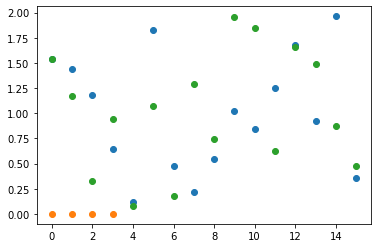

In [176]:
#IBVP parameters
N_interior =  2**4
N_bc = 2**4
N_ic = 4
T = 2

# Generate training set
X_train = temporal_sample(T, N_interior, N_ic, N_bc, kind="lhs")
t_int, t_ic, t_bc = X_train
print(t_int.shape, t_ic.shape, t_bc.shape)

# Generate test data
X_test = temporal_sample(T, N_interior, N_ic, N_bc, kind="lhs")

plt.scatter(np.arange(len(t_int)), t_int)
plt.scatter(np.arange(len(t_ic)), t_ic)
plt.scatter(np.arange(len(t_bc)), t_bc)

plt.show()

### Train the Network

In [178]:
hp = {"optimizer":"adam", 
      "optimizer_params":{"lr":1e-3}, 
      "hidden_layers":[30,30,30], 
      "number_of_minibatches":1,
      "epochs":10000}

eigen_nn = PiNN(eigenvector_ode, noop, noop, trial_function, 
                hooks=[monitor_eigenvalue_evolution, monitor_eigenvector_evolution],
                verbose=True, hyperparameters=hp)
print(eigen_nn)
eigen_nn.fit(X_train, None)

NN(
  (ff_graph): Sequential(
    (0): Linear(in_features=1, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
  )
  (output): Linear(in_features=30, out_features=6, bias=True)
)
model parameters:                                                 2106
---------------------------Hyperparameters----------------------------
hidden_layers                                             [30, 30, 30]
epochs                                                           10000
number_of_minibatches                                                1
optimizer                                                         adam
optimizer_params                                         {'lr': 0.001}

-----------------------------Training Log-----------------------------
# of collocation points:                                            16
# of boundary points:              

In [179]:
#Ground Truth
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Sort in descending order
permutation = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[permutation]
eigenvectors = eigenvectors[permutation]
print(f"Sp(A) = {eigenvalues}")
print(f"max{{ Sp(A) }} = {np.max(eigenvalues)}")
print(f"eigenvector = {eigenvectors[0]}")

Sp(A) = [ 0.80563579  0.52059255  0.36237071  0.16040342 -0.00695199 -0.74830531]
max{ Sp(A) } = 0.8056357887193072
eigenvector = [-0.84820687 -0.25335134 -0.07119891  0.29135455  0.04441407  0.3527447 ]


In [180]:
x_from_power = power_iteration(A.numpy(), N=1000)
ev_from_power = eigenvalue_of_eigenvector(x_from_power, A.numpy())
print(f"eigenvalue (power method) = {ev_from_power}")
print(f"eigenvector (power method) = {x_from_power}")

eigenvalue (power method) = 0.8056357887193072
eigenvector (power method) = [-0.3622938   0.12126143 -0.42200997  0.6148536  -0.41650052 -0.3527447 ]


In [181]:
x = eigen_nn.predict(torch.tensor([1.]).reshape(1,1))
ev_from_network = eigenvalue_of_eigenvector(x, A.numpy()).item()
print(f"eigenvalue (network) = {ev_from_network}")
print(f"eigenvector (network) = {x}")
print(f"closest eigenvalue = {eigenvalues[closest_ev_idx]}")
print("Overlaps of IC")
for eigenvector, eigenvalue in zip(eigenvectors, eigenvalues):
    print(np.abs(ic.y0 @ eigenvector), eigenvalue)
    
closest_ev_idx = np.argmin(np.abs(eigenvalues - ev_from_network))

eigenvalue (network) = 0.3480571218331534
eigenvector (network) = tensor([[ 0.7946,  0.0672,  0.2399,  0.4469,  0.3259, -0.0167]])
closest eigenvalue = 0.3623707075490041
Overlaps of IC
tensor([0.4063]) 0.8056357887193072
tensor([0.0251]) 0.5205925499651505
tensor([0.6695]) 0.3623707075490041
tensor([0.2987]) 0.16040342299685278
tensor([0.2760]) -0.006951991235870985
tensor([0.4698]) -0.7483053062804309


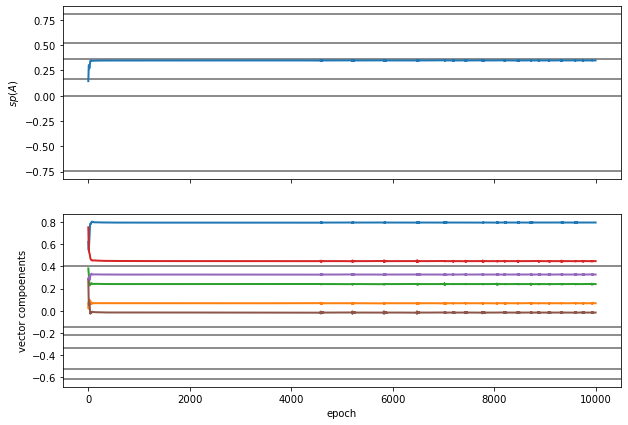

In [182]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,7))
for ev in eigenvalues:
    ax[0].axhline(y=ev, color="dimgray")
for component in eigenvectors[closest_ev_idx]:
    ax[1].axhline(y=component, color="dimgray")

ev_evolution = np.array(eigen_nn.hooks_returns["monitor_eigenvalue_evolution"]).squeeze()
vector_evolution = np.array(eigen_nn.hooks_returns["monitor_eigenvector_evolution"]).squeeze().T
ax[0].plot(ev_evolution, lw=2)
for element_evolution in vector_evolution:
    ax[1].plot(element_evolution, lw=2)
ax[1].set_xlabel(r"epoch")
ax[0].set_ylabel(r"$sp(A)$")
ax[1].set_ylabel(r"vector compoenents")
plt.show()